In [1]:
from __future__ import print_function
import torch
import numpy as np
import sinkhorn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import train
import argparse
import timeit
import util
from linear_run import *
import itertools

one = torch.FloatTensor([1])

In [2]:
def average(v, stepsize=1e-3):
    """
    Average time series on intervals of size stepsize
    """
    v = v[v[:,1].argsort()] 
    h = np.histogram(v[:, 1], bins=np.arange(v[0,1], v[-1, 1], stepsize))
    h_ind = np.where(h[0])
    ind = np.cumsum(h[0][h_ind])
    ind = np.concatenate((np.zeros(1), ind)).astype(int)
    h = h[1][h_ind]
    z = [np.mean(v[ind[i]:ind[i+1], 0]) for i in range(len(h))]
    return h, z

In [3]:
K = 100
dim = 40
lamb = 0.1
expstart = 1
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)
nexp = 200
cost = sinkhorn._linear_cost
losses = {}

device = torch.device("cpu")
#device = torch.device("cuda:0")

# Sinkhorn

In [4]:
sinkiterrange = [5]
sinklrrange = [10]

In [5]:
losses['sinkhorn'] = {}
for s in itertools.product(sinkiterrange, sinklrrange):
    sinkiter, sinklr = s[0], s[1]
    losses['sinkhorn'][(sinkiter, sinklr)] = []
    for exp in range(expstart, expstart+nexp):
        l = np.load('experiments/sinkhorn/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn_{6}/losses.npy'.format(exp, lamb, K, dim, sinkiter, sinklr, device))
        t = np.load('experiments/sinkhorn/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn_{6}/time.npy'.format(exp, lamb, K, dim, sinkiter, sinklr, device))
        losses['sinkhorn'][(sinkiter, sinklr)] += zip(l, t)

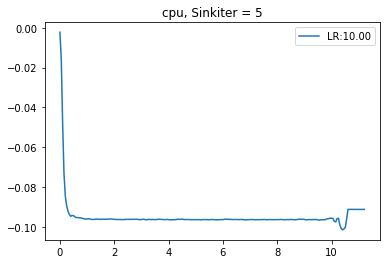

In [6]:
for sinkiter in sinkiterrange:
    plt.figure()
    for sinklr in sinklrrange:
        h, z = average(np.array(losses['sinkhorn'][(sinkiter, sinklr)]), stepsize=5e-2)
        plt.plot(h, z, label='LR:{0:.2f}'.format(sinklr))
    plt.legend()
    plt.title('{}, Sinkiter = {}'.format(device, sinkiter))
    plt.show()

# Descent

In [7]:
descentlrrange = [100.]

In [8]:
losses['descent'] = {}

for descentlr in descentlrrange:
    losses['descent'][descentlr] = []
    for exp in range(expstart, expstart+nexp):
        l = np.load('experiments/descent/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent_{5}/losses.npy'.format(exp, lamb, K, dim, descentlr, device))
        t = np.load('experiments/descent/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent_{5}/time.npy'.format(exp, lamb, K, dim, descentlr, device))
        losses['descent'][descentlr] += zip(l,t)

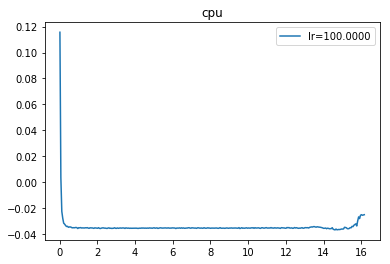

In [9]:
plt.figure()
for descentlr in descentlrrange:
    h, z = average(np.array(losses['descent'][descentlr]), stepsize=5e-2)
    plt.plot(h,z, label='lr={0:.4f}'.format(descentlr))
plt.legend()
plt.title(device)
plt.show()

# DC

In [10]:
dclrrange = [1e-4]
dcdualiterrange = [5.]

In [11]:
losses['dc'] = {}
for s in itertools.product(dcdualiterrange, dclrrange):
    dcdualiter, dclr = s[0], s[1]
    losses['dc'][(dcdualiter, dclr)] = []
    for exp in range(expstart, expstart+nexp):
        l = np.load('experiments/dc/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc_{6}/losses.npy'.format(exp, lamb, K, dim, dcdualiter, dclr, device))
        t = np.load('experiments/dc/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc_{6}/time.npy'.format(exp, lamb, K, dim, dcdualiter, dclr, device))
        losses['dc'][(dcdualiter, dclr)] += zip(l, t)    

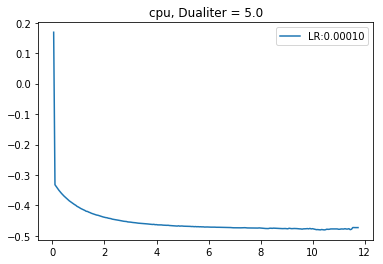

In [12]:
for dcdualiter in dcdualiterrange:
    plt.figure()
    for dclr in dclrrange:
        h, z = average(np.array(losses['dc'][(dcdualiter, dclr)]), stepsize=5e-2)
        plt.plot(h, z, label='LR:{0:.5f}'.format(dclr))
    plt.legend()
    plt.title('{}, Dualiter = {}'.format(device, dcdualiter))
    plt.show()

# Plot all

In [14]:
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

In [13]:
print(sinkiterrange)
print(sinklrrange)
print(descentlrrange)
print(dcdualiterrange)
print(dclrrange)

[5]
[10]
[100.0]
[5.0]
[0.0001]


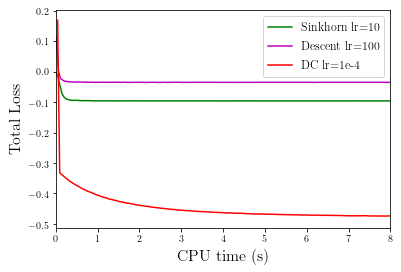

In [15]:
plt.figure()

sinkiter, sinklr = 5, 10
h, z = average(np.array(losses['sinkhorn'][(sinkiter, sinklr)]), stepsize=5e-2)
plt.plot(h, z,'g', label='Sinkhorn lr={}'.format((int)(sinklr)))

#descentlr = 1e-5
#h, z = average(np.array(losses['descent'][descentlr]), stepsize=5e-2)
#plt.plot(h,z,'b', label='Descent lr={}'.format(descentlr))

descentlr = 100.
h, z = average(np.array(losses['descent'][descentlr]), stepsize=5e-2)
plt.plot(h,z,'m', label='Descent lr={}'.format((int)(descentlr)))

dcdualiter, dclr = 5., 1e-4
h, z = average(np.array(losses['dc'][(dcdualiter, dclr)]), stepsize=5e-2)
plt.plot(h, z, 'r', label='DC lr=1e-4')

#dcdualiter, dclr = 5, 1e-5
#h, z = average(np.array(losses['dc'][(dcdualiter, dclr)]), stepsize=5e-2)
#plt.plot(h, z, 'orange', label='DC lr={}'.format(dclr))
    
plt.legend(fontsize=12)
plt.xlabel('CPU time (s)',fontsize=16)
plt.ylabel('Total Loss',fontsize=16)
plt.xlim(0, 8)
#plt.ylim(-0.2, 0.5)
#plt.title('{}, Sinkiter = {}'.format(device, sinkiter))
plt.savefig('figures/lamb01_K{}_dim{}.pgf'.format(K, dim))
plt.show()

In [15]:
print(lamb)

0.5
